In [1]:
import gym
import logging
import numpy as np
import offworld_gym
from offworld_gym.envs.common.channels import Channels
import matplotlib
matplotlib.use('tkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.DEBUG)


In [2]:
import sys
path_to_be = "/opt/ros/kinetic/lib/python2.7/dist-packages"
sys.path.remove(path_to_be)
import cv2
sys.path.append(path_to_be)

In [3]:
# create the environment
env = gym.make("OffWorldMonolithDiscreteSim-v0", channel_type=Channels.RGBD)
env.seed(42)

INFO:rospy.topics:topicmanager initialized
INFO:rosout:The environment has been started.


Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
waiting for rosbot model to init...
waiting for publications to /clock...
[INFO] [1599624912.822612]: Environment has been initiated.
[INFO] [1599624912.823344]: Service proxies have been initiated.
[INFO] [1599624912.831671]: Environment has been started.


[42]

In [4]:
# env.close()
def resizing_uptoscale(img , scale_down = 30):
    scale_percent = 100-scale_down # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    return resized
def givingscaledownDim(original_dim , scale_down = 30):
    scale_percent = 100-scale_down # percent of original size
    width = int(original_dim[0] * scale_percent / 100)
    height = int(original_dim[1] * scale_percent / 100)
    return (width,height)

In [5]:

def extract_luminance(image):
    print("image", image.shape)
    luminance = np.sqrt(0.599*np.power(image[:,:,0],2) + 0.787*np.power(image[:,:,1],2) + 0.074*np.power(image[:,:,1],2))
    return luminance
def scale_lumininance(img):
    print(img.shape)
    return np.dot(img[...,:3], [0.1, 0.2, 0.0])



In [6]:
size = givingscaledownDim((240,320) , scale_down = 30)
print(size)

(168, 224)


[]
(480, 640, 3)
image (480, 640, 3)
(480, 640, 3)


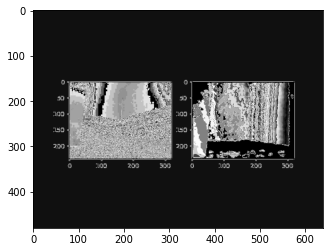

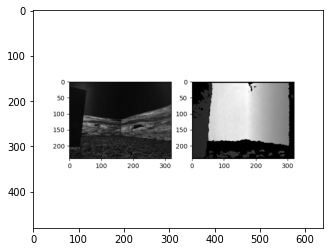

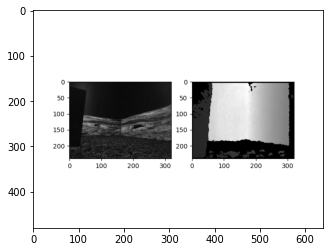

In [7]:
import glob

print(glob.glob(''))
img = cv2.imread('tech_round/Figure_12.png')
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
img_1 = extract_luminance(img)
img_2 = scale_lumininance(img)
plt.imshow(img_1 , cmap ='gray')
plt.show()
plt.imshow(img_2 , cmap='gray')
plt.show()
plt.imshow(img_gray , cmap ='gray')
plt.show()

In [ ]:
## logging.info(f"action space: {env.action_space} observation_space: {env.observation_space}")
for i in range(3):
    env.reset()
    done = False
    get_proper = False
    while not done:
        while not get_proper:
            sampled_action = int(input("give an action"))
            if sampled_action in [0,1,2,3]:
                get_proper = True
            else:
                print("invalid action select between 0 1 2 3")
        get_proper = False 
        env.render()
        obs, rew, done, info = env.step(sampled_action)
        print(obs[0].shape)
        obs = np.array(obs)
#         plt.imshow(obs[0])
#         plt.show()
        rbg_img = obs[0][:,:,:3]
        dep_img = obs[0][:,:,3]
        img_gray = cv2.cvtColor(rbg_img, cv2.COLOR_BGR2GRAY)
        scaled_down_gray = resizing_uptoscale(img_gray , scale_down = 30)
        deo_down = resizing_uptoscale(dep_img , scale_down = 40)
        observation = np.vstack((img_gray, dep_img))
        
        plt.imshow(img_gray)
        plt.show()
        
        plt.imshow(dep_img , cmap='gray')
        plt.show()
        
        
        
        plt.imshow(scaled_down_gray)
        plt.show()
        
        plt.imshow(deo_down , cmap='gray')
        plt.show()
        
#         img_sc = extract_luminance(obs[0])
#         img_sc_2 = scale_lumininance(obs[0])
#         plt.imshow(img_sc)
#         plt.show()
#         plt.imshow(img_sc_2)
#         plt.show()
#         plt.imshow(img_gray , cmap='gray')
#         plt.show()
        
        
#         obs = cv2.resize(obs[0] , (64,64))
#         print("the observation", obs.shape , "the current reward", rew , "sample action", sampled_action)
#         plt.imshow(obs)
#         plt.show()
#         print("showing the plot")

In [ ]:
from offworld_gym import version

__version__     = version.__version__

import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import sys, pdb, time, glob
import numpy as np
from datetime import datetime
import pickle

# configure tensorflow and keras
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

import gym
import offworld_gym
from offworld_gym.envs.common.channels import Channels

import keras
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Flatten, Conv2D, Input, MaxPooling2D, LeakyReLU, BatchNormalization, Permute
from keras.optimizers import Adam

from kerasrl.agents.dqn import DQNAgent
from kerasrl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from kerasrl.memory import SequentialMemory
from kerasrl.processors import Processor
from kerasrl.callbacks import ModelIntervalCheckpoint, TerminateTrainingOnFileExists, SaveDQNTrainingState, Visualizer

from utils import TB_RL, GetLogPath


# define paths
NAME              = 'sim_offworld_monolith-{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
OFFWORLD_GYM_ROOT = os.environ['OFFWORLD_GYM_ROOT']
LOG_PATH          = '%s/logs/sim' % OFFWORLD_GYM_ROOT
MODEL_PATH        = '%s/models/sim' % OFFWORLD_GYM_ROOT
STATE_PATH        = '/media/caplab/Seagate Backup Plus Drive/Adithya/Off_world/Off_world/sim_agent_state'

if not os.path.exists(LOG_PATH): os.makedirs(LOG_PATH)
if not os.path.exists(MODEL_PATH): os.makedirs(MODEL_PATH)


# !ls


In [ ]:
 # agent parameters
    memory_size = 20000
    window_length = 4
    total_nb_steps = 5000
    exploration_anneal_nb_steps = 2000
    max_eps = 0.8
    min_eps = 0.1
    learning_warmup_nb_steps = 50
    target_model_update = 1e-2
    learning_rate = 1e-3
    # callback parameters
    model_checkpoint_interval = 100000 # steps
    verbose_level = 2                # 1 for step interval, 2 for episode interval
    log_interval = 200               # steps
    save_state_interval = 5001       # episodes
